# NMF Practical Work

**Umut Simsekli, Bertrand David, Paul Magron** 

Telecom Paris

In [1]:
import numpy as np

# matplotlib for displaying the output
import matplotlib.pyplot as plt
import matplotlib.style as ms
# ms.use('seaborn-muted')
%matplotlib inline

# and IPython.display for audio output
import IPython.display as ipd

# Librosa for audio
import librosa
# # And the display module for visualization
import librosa.display


<Figure size 640x480 with 0 Axes>

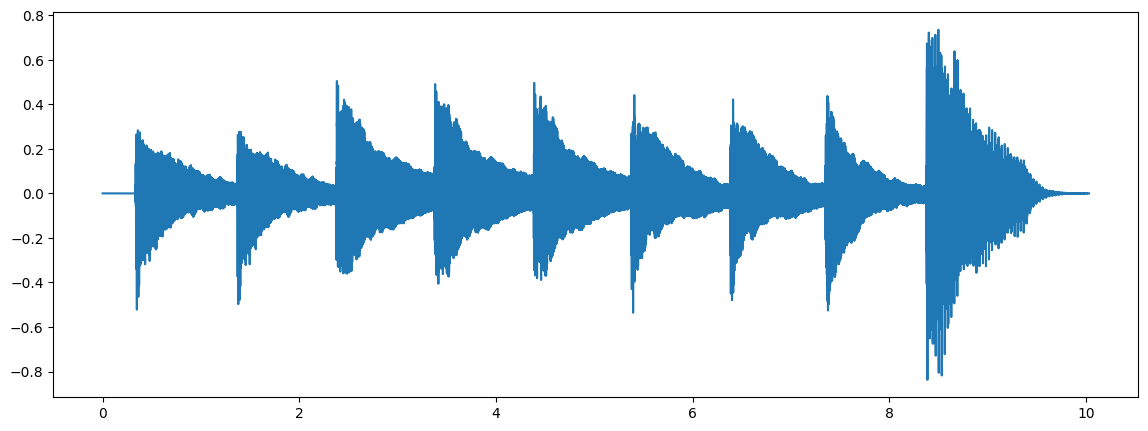

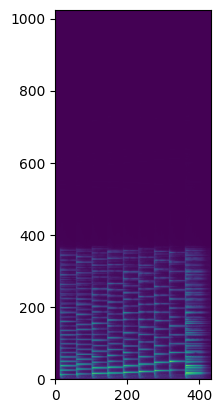

In [9]:
# Audio file
fname = 'Cmajor_piano8khz.wav'

# Load signal
y, sr = librosa.load(fname)

# Compute STFT
Xstft = librosa.stft(y, n_fft=2048, hop_length=512, win_length=None)
X = np.abs(Xstft)

#Visualize the waveform
plt.figure()
plt.figure(figsize=(14, 5))
# librosa.display.waveshow(y, sr=sr)
plt.plot(np.arange(0, len(y)) / sr, y)

#Visualize the spectrum
plt.figure()
plt.imshow(X**0.3)
plt.gca().invert_yaxis()


In [3]:
# Implement MUR for NMF with beta-divergence 



In [10]:
# Example reconstruction
y_hat = librosa.istft(Xstft)
ipd.Audio(y_hat, rate=sr)


In [11]:
def build_signal(notes, Fs):
    """
%  Signal synthesis from piano isolated notes
%  
% 
% Inputs :
%     notes : matrix of notes with 4 lines : pitch, t onset, durations and
%     velocity
%     Fs : sample rate (in Hz)
%
% Outputs :
%     x : synthesis signal
    """
    pitch = notes[0, :]
    t_on = notes[1, :]
    durations = notes[2, :]
    vel = notes[3, :]
    Nnotes = len(pitch)
    Lsig = int((t_on[-1]+durations[-1])*Fs)
    x = np.zeros(Lsig)
    for n in range(Nnotes):
        # Get midi index
        ind_pitch = pitch[n]
        Lnote = int(durations[n]*Fs)
        
        # Read piano note
        xt, sr = librosa.load('data/{}.wav'.format(str(int(ind_pitch))))
        xt = librosa.resample(xt, sr, Fs)
        xt = xt[:Lnote] * vel[n]
        
        # Fill the current melodic line
        deb = int(t_on[n]*Fs)
        fin = deb + Lnote
        x[deb:fin] += xt
    return x

# 1 Non-Negative Matrix Factorization with β-divergence

When we differentiate the cost function, we obtain:

$$
\frac{\partial d_\beta}{\partial W} = 0 = - \frac{(\beta - 1) X (WH)^{\beta - 2} H^T}{\beta - 1} + \frac{\beta (WH)^{\beta - 1} H^T}{\beta}
$$

Simplifying, we get:

$$
\frac{\partial d_\beta}{\partial W} = -X (WH)^{\beta - 2} H^T + (WH)^{\beta - 1} H^T
$$

So when we do a gradient descent on $(W)$:

$$
W \leftarrow W - \eta_W \left( -X (WH)^{\beta - 2} H^T + (WH)^{\beta - 1} H^T \right)
$$

If we take $\eta_W = \frac{W}{(WH)^{\beta - 1} H^T}$, we then have:

$$
W \leftarrow W - \frac{W}{(WH)^{\beta - 1} H^T} \left( -X (WH)^{\beta - 2} H^T + (WH)^{\beta - 1} H^T \right)
$$

Simplifying further, we get:

$$
W \leftarrow W + W \circ \frac{X (WH)^{\beta - 2} H^T}{(WH)^{\beta - 1} H^T} - W
$$

Therefore, the multiplicative update rule for $W$ is:

$$
W \leftarrow W \circ \frac{X (WH)^{\beta - 2} H^T}{(WH)^{\beta - 1} H^T}
$$

Now we do the same for $H$:

$$
\frac{\partial d_\beta}{\partial H} = 0 = - \frac{(\beta - 1) W^T (X (WH)^{\beta - 1})}{\beta - 1} + \frac{\beta W^T (WH)^{\beta - 1}}{\beta}
$$

Simplifying, we get:

$$
\frac{\partial d_\beta}{\partial H} = - W^T (X (WH)^{\beta - 2}) + W^T (WH)^{\beta - 1}
$$

So we have when doing a gradient descent:

$$
H \leftarrow H - \eta_H \left( -W^T (X \circ (WH)^{\beta - 2}) + W^T (WH)^{\beta - 1} \right)
$$

If we take $\eta_H = \frac{H}{W^T (WH)^{\beta - 1}}$, then we obtain:

$$
H \leftarrow H - \frac{H}{W^T (WH)^{\beta - 1}} \left( -W^T (X \circ (WH)^{\beta - 2}) + W^T (WH)^{\beta - 1} \right)
$$

Simplifying further, we get:

$$
H \leftarrow H + H \circ \frac{W^T (X \circ (WH)^{\beta - 2})}{W^T (WH)^{\beta - 1}} - H
$$

Therefore, the multiplicative update rule for $H$ is:

$$
H \leftarrow H \circ \frac{W^T (X \circ (WH)^{\beta - 2})}{W^T (WH)^{\beta - 1}}
$$


# 2 Variations on a simple example

## 2.1 Construction of the simple example

In [102]:
def hann_window(f, width=80):
    # centralized at 0, width [Hz]
    w = 0.5 * (1 + np.cos(2 * np.pi * f / width))
    w[np.abs(f) > width / 2] = 0
    return w

def harmonic_spectrum(F0_r, Fe=8000, Nfft=512, window_width=80):
    f = np.linspace(0, Fe, Nfft)
    W_r = np.zeros_like(f)
    K_r = int(Fe / 2 / F0_r)

    for k in range(1, K_r + 1):
        a_k = np.exp(-k / K_r)
        f_k = k * F0_r
        if f_k > Fe / 2: break
        W_k = a_k * hann_window(f - f_k, window_width)
        W_r += W_k

    return f, W_r

def get_Ws(F0, Fe=8000, Nfft=512, window_width=80):
    Ws = []
    plt.figure(figsize=(7, 4))
    for r, F0_r in enumerate(F0):
        f, W_r = harmonic_spectrum(F0_r, Fe, Nfft, window_width)
        half_Nfft = Nfft // 2
        W_r_half = W_r[:half_Nfft]
        W_r[half_Nfft:] = W_r_half[::-1]
        plt.plot(f, W_r, label=f'F0 = {F0_r} Hz')
        Ws.append(W_r)
    
    plt.title("Harmonic Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid()
    plt.show()
    return np.array(Ws).T

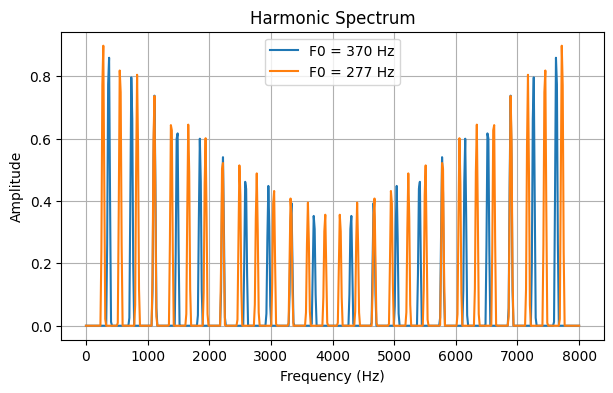

In [103]:
F0 = [370, 277]
Fe = 8000
Nfft = 512
K_r = int(Nfft / 2)
window_width = 80

Ws = get_Ws(F0, Fe, Nfft, window_width)

[1, 0, 1]
[0, 1, 1]


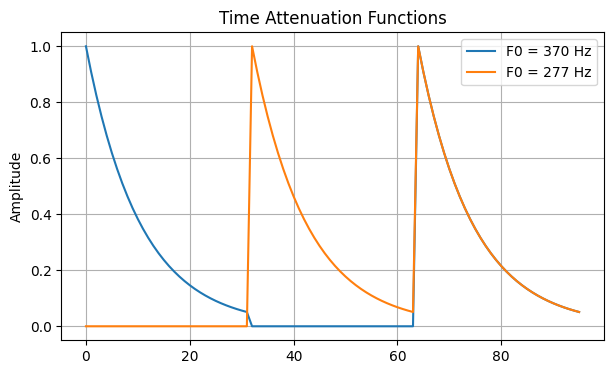

In [108]:
def h(t, tau):
    return np.exp(-t / tau) * (t >= 0)

def get_Hs(b_p, F0, Fe=8000, Nfft=512, delta_T=0.5, attenuation_factor=3):
    Fh = Fe / (Nfft / 4)
    tau = delta_T / attenuation_factor
    Hs = []
    plt.figure(figsize=(7, 4))
    for r, F0_r in enumerate(F0):
        t = np.arange(0, delta_T, 1/Fh)
        h_r = []
        print(b_p[r])
        for idx, b in enumerate(b_p[r]):
            h_r = np.concatenate((h_r, b* h(t, tau)))
        Hs.append(h_r)
        t = np.arange(0, delta_T * len(b_p[r]), 1/Fh)
        plt.plot(h_r, label=f'F0 = {F0_r} Hz')
    plt.title("Time Attenuation Functions")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid()
    plt.show()
    return np.array(Hs)

b_p = [[1, 0, 1], [0, 1, 1]]
Hs = get_Hs(b_p, F0)

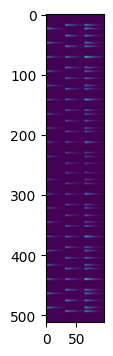

In [109]:
Xs = np.dot(Ws, Hs)
plt.figure(figsize=(7, 4))
plt.imshow(Xs)

y_hat = librosa.istft(Xs, n_fft=Nfft)
ipd.Audio(y_hat, rate=Fe)

In [123]:
def MUR(X, k, beta=2, iterations=100):
    X = X + 1e-6
    # Initialisation de W et H
    i, j = X.shape
    W = np.random.rand(i, k)
    H = np.random.rand(k, j)
    cost_functions = []
    for _ in range(iterations):

        X_hat = W@H +1e-6
        tmp = X * np.power(X_hat, beta-2)
        tmp = tmp @ H.T
        tmp = tmp / (np.power(X_hat, beta-1)@ H.T)
        W = W * tmp

        X_hat = W @ H +1e-6
        tmp = X * np.power(X_hat, beta-2)
        tmp = W.T @ tmp
        tmp = tmp / (W.T @ np.power(X_hat, beta-1))
        H = H * tmp

        x_norm = np.linalg.norm(X)
        x_hat_norm = np.linalg.norm(X_hat)
        # cost function
        if beta == 1:
            cost = x_norm*np.log(X / X_hat) - X + X_hat
        else:
            cost = X**beta / beta * (beta-1) - X * X_hat**(beta-1) / (beta-1) + X_hat**beta / beta
        cost = np.linalg.norm(cost) / len(cost)
        
        cost_functions.append(cost)
        # normalisation
        W = W / W.sum(axis=0)
        H = H / H.sum(axis=1)[:, None]
    # cost_functions = np.linalg.norm(cost_functions) / len(cost_functions)
    return W, H, cost_functions

W, H, C = MUR(Xs, 2, beta=2)


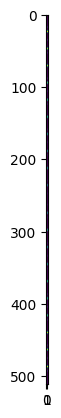

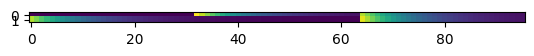

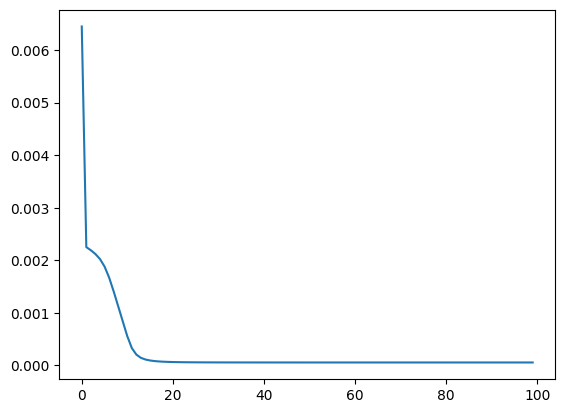

In [124]:
plt.imshow(W)
plt.show()
plt.imshow(H)
plt.show()
plt.plot(C)
plt.show()